In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI1/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
!tar -xzf adni1_brain_resid.tar.gz

In [ ]:
!tar -xzf adni1_brain_stand.tar.gz

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

In [ ]:
import re

def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

def filter_missing_data(images, labels, existing_ids):

    zipped_set = list(zip(images, labels))

    zipped_set = list(filter(lambda x: image_exists(x, existing_ids), zipped_set))

    images, labels = zip(*zipped_set)

    return images, labels

id_to_path = make_id_translator(images)

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


class TheActualGRU(nn.Module):

  def __init__(self, num_classes=3):
    super(TheActualGRU, self).__init__()

    self.bgru_1 = nn.GRU(640, 640, batch_first = True, bidirectional = True) # output: x: (N,L,2∗H_out), h_n: (2∗num_layers,N,H_out​)
    self.bgru_2 = nn.GRU(1280, 200, batch_first = True, bidirectional = True)
    self.dropout_1 = nn.Dropout(p = 0.2)
    self.bgru_3 = nn.GRU(400, 50, batch_first = True, bidirectional = True)
    self.fc1 = nn.Linear(100, 50)
    self.dropout_2 = nn.Dropout(p = 0.2)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x):
    # h0 = torch.zeros(2, x.size(0), 300).to(x.device) # defaults to zero if not provided

    x, _ = self.bgru_1(x)
    x, _ = self.bgru_2(x)
    x = self.dropout_1(x)
    x, _ = self.bgru_3(x)
    x = x[:, -1, :]
    x = self.fc1(x)
    x = self.dropout_2(x)
    x = self.fc2(x)

    return x


class CRNN(nn.Module):

  def __init__(self, tp0, tp1, tp2, tp3, tp4, tp5, bgru=None, num_classes=3):
    super(CRNN, self).__init__()

    self.tp0, self.tp1, self.tp2, self.tp3, self.tp4, self.tp5 = tp0, tp1, tp2, tp3, tp4, tp5

    if bgru is not None:
      self.bgru = bgru
    else:
      self.bgru = TheActualGRU(num_classes=3)

  def forward(self, x): # x: 4, 1, 6, 182, 218, 182

    tp0_out = self.tp0(x[:,:,0,:,:,:])
    tp1_out = self.tp1(x[:,:,1,:,:,:])
    tp2_out = self.tp2(x[:,:,2,:,:,:])
    tp3_out = self.tp3(x[:,:,3,:,:,:])
    tp4_out = self.tp4(x[:,:,4,:,:,:])
    tp5_out = self.tp5(x[:,:,5,:,:,:])

    t_out = torch.stack([tp0_out, tp1_out, tp2_out, tp3_out, tp4_out, tp5_out], dim=1)

    out = self.bgru(t_out)

    return out


### load pretrained

In [ ]:
import os
import shutil

def load_pretrained(filename='run_checkpoint.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  if not os.path.isfile(filename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints/part2/timepoints/{filename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    print(re)

    # old_state = checkpoint['model_state_dict']

    # new_state = model.state_dict()

    # assert len(old_state.keys()) == len(new_state.keys())

    # new_to_old = {}
    # for kn, ko in zip(new_state.keys(), old_state.keys()):
    #   new_to_old[kn] = ko

    # for key, value in new_state.items():

    #   if 'conv_block' in key:
    #     weights = old_state[key.replace('conv_block.', '')]
    #   else:
    #     weights = old_state[key]

    # model.load_state_dict(new_state, strict=True)

  for param in model.parameters():
    param.requires_grad = False

  return model

def load_pretrained_timeless(filename='combined_fullnetwork11_adni1.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  savename = f'{num_classes}c_{filename}'

  if not os.path.isfile(savename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints/part2/{savename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(savename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(savename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    print(re)

  for param in model.parameters():
    param.requires_grad = False

  return model

In [ ]:
def load_whole_model(num_classes=2):

  tp0 = load_pretrained(filename=f"{num_classes}c_timepoint-sc_fullnetwork11_adni1.pth", num_classes=num_classes).encoder
  tp1 = load_pretrained(filename=f"{num_classes}c_timepoint-m06_fullnetwork11_adni1.pth", num_classes=num_classes).encoder
  tp2 = load_pretrained(filename=f"{num_classes}c_timepoint-m12_fullnetwork11_adni1.pth", num_classes=num_classes).encoder
  tp3 = load_pretrained(filename=f"{num_classes}c_timepoint-m18_fullnetwork11_adni1.pth", num_classes=num_classes).encoder
  tp4 = load_pretrained(filename=f"{num_classes}c_timepoint-m24_fullnetwork11_adni1.pth", num_classes=num_classes).encoder
  tp5 = load_pretrained(filename=f"{num_classes}c_timepoint-m36_fullnetwork11_adni1.pth", num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

def load_whole_model_timeless(num_classes=2):

  tp0 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp1 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp2 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp3 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp4 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp5 = load_pretrained_timeless(num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

In [ ]:
from torchsummary import summary

In [ ]:
summary(load_whole_model_timeless(), (1, 6, 182, 218, 182), device='cpu')

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI1_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI1_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)


In [ ]:
def reorder_images(group, dset='adni1'):
    if dset == 'adni1':
        order_mapping = {'sc': 0, 'm06': 1, 'm12': 2, 'm18': 3, 'm24': 4, 'm36': 5}
    else:
        order_mapping = {'sc': 0, 'y1': 1, 'y2': 2, 'y3': 3, 'y4': 4, 'y5': 5}
    result = [None] * 6
    for index, row in group.iterrows():
        result[order_mapping[row['Visit']]] = row['Image Data ID']
    return result

In [ ]:
def id_to_path_with_none(id):
  if id is None:
    return None
  return id_to_path[id]

In [ ]:
train_imagelist = tuning_df[tuning_df['Subject'].isin(train_subjects)].groupby('Subject')[['Visit', 'Image Data ID']].apply(reorder_images).rename('ImageIDs')
train_df = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).merge(train_imagelist, left_on='Subject',right_index=True)[['ImageIDs', 'Group']]
train_imagelist, train_labels = train_df.T.to_numpy()
train_image_paths = [[id_to_path_with_none(id) for id in sbj_list] for sbj_list in train_imagelist]

In [ ]:
valid_imagelist = tuning_df[tuning_df['Subject'].isin(valid_subjects)].groupby('Subject')[['Visit', 'Image Data ID']].apply(reorder_images).rename('ImageIDs')
valid_df = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).merge(valid_imagelist, left_on='Subject',right_index=True)[['ImageIDs', 'Group']]
valid_imagelist, valid_labels = valid_df.T.to_numpy()
valid_image_paths = [[id_to_path_with_none(id) for id in sbj_list] for sbj_list in valid_imagelist]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)
        # img_data = (img_data - mn) / (mx - mn)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


class CRNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path_list = self.file_paths[idx]
        label = self.labels[idx]

        images = []

        for file_path in file_path_list:

          if file_path is None:
            none_img = np.ones((182,218,182)) * -1
            images.append(none_img)
            continue

          # Load NIfTI image
          nifti_img = nib.load(file_path)

          # Get the image data
          img_data = nifti_img.get_fdata()

          # Assuming the data is in a reasonable range, you may normalize it
          max_i = img_data.max()
          min_i = img_data.min()
          img_data = (img_data - min_i) / (max_i - min_i)

          images.append(img_data)

        stacked_images = np.stack(images, axis=0)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(stacked_images, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 1, 4, 2, 3)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)


y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CRNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CRNNDataset(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 8
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
n_classes

3

In [ ]:
len(train_loader)

68

In [ ]:
len(valid_loader)

9

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints/part3' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '3c_crnn_timeless_adni1.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = load_whole_model_timeless(num_classes=3)
model.to(device)

# Number of training epochs
num_epochs = 10

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8712
Training Accuracy: 59.93%
Training F1-Score: 59.23%
           AD        CN       MCI
AD   0.519380  0.023256  0.457364
CN   0.154362  0.409396  0.436242
MCI  0.195402  0.057471  0.747126


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.8133
Validation Accuracy: 65.67%
Validation F1-Score: 65.10%
           AD        CN       MCI
AD   0.562500  0.000000  0.437500
CN   0.315789  0.473684  0.210526
MCI  0.093750  0.093750  0.812500
Epoch 0: SGD lr 0.000040 -> 0.000039
Epoch 0: saving...
Epoch 1:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6666
Training Accuracy: 76.07%
Training F1-Score: 76.23%
           AD        CN       MCI
AD   0.728682  0.000000  0.271318
CN   0.208054  0.671141  0.120805
MCI  0.111111  0.061303  0.827586


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7579
Validation Accuracy: 65.67%
Validation F1-Score: 64.73%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.062500  0.093750  0.843750
Epoch 1: SGD lr 0.000039 -> 0.000038
Epoch 1: saving...
Epoch 2:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5857
Training Accuracy: 77.92%
Training F1-Score: 77.90%
           AD        CN       MCI
AD   0.744186  0.000000  0.255814
CN   0.181208  0.671141  0.147651
MCI  0.088123  0.053640  0.858238


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7262
Validation Accuracy: 65.67%
Validation F1-Score: 64.73%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.062500  0.093750  0.843750
Epoch 2: SGD lr 0.000038 -> 0.000037
Epoch 2: saving...
Epoch 3:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5606
Training Accuracy: 77.37%
Training F1-Score: 77.41%
           AD        CN       MCI
AD   0.751938  0.000000  0.248062
CN   0.181208  0.671141  0.147651
MCI  0.099617  0.057471  0.842912


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7220
Validation Accuracy: 67.16%
Validation F1-Score: 65.94%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.031250  0.093750  0.875000
Epoch 3: SGD lr 0.000037 -> 0.000036
Epoch 3: saving...
Epoch 4:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5335
Training Accuracy: 77.18%
Training F1-Score: 77.05%
           AD        CN       MCI
AD   0.697674  0.000000  0.302326
CN   0.161074  0.671141  0.167785
MCI  0.076628  0.057471  0.865900


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6988
Validation Accuracy: 67.16%
Validation F1-Score: 65.94%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.031250  0.093750  0.875000
Epoch 4: SGD lr 0.000036 -> 0.000035
Epoch 4: saving...
Epoch 5:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5109
Training Accuracy: 78.29%
Training F1-Score: 78.05%
           AD        CN       MCI
AD   0.689922  0.000000  0.310078
CN   0.174497  0.671141  0.154362
MCI  0.053640  0.053640  0.892720


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7031
Validation Accuracy: 65.67%
Validation F1-Score: 65.88%
           AD        CN       MCI
AD   0.750000  0.000000  0.250000
CN   0.368421  0.473684  0.157895
MCI  0.187500  0.093750  0.718750
Epoch 5: SGD lr 0.000035 -> 0.000034
Epoch 5: saving...
Epoch 6:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4977
Training Accuracy: 77.18%
Training F1-Score: 77.27%
           AD        CN       MCI
AD   0.728682  0.000000  0.271318
CN   0.174497  0.677852  0.147651
MCI  0.107280  0.045977  0.846743


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7056
Validation Accuracy: 68.66%
Validation F1-Score: 68.30%
           AD        CN       MCI
AD   0.687500  0.000000  0.312500
CN   0.368421  0.473684  0.157895
MCI  0.093750  0.093750  0.812500
Epoch 6: SGD lr 0.000034 -> 0.000033
Epoch 6: saving...
Epoch 7:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4850
Training Accuracy: 78.11%
Training F1-Score: 78.00%
           AD        CN       MCI
AD   0.705426  0.000000  0.294574
CN   0.181208  0.684564  0.134228
MCI  0.068966  0.057471  0.873563


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6961
Validation Accuracy: 65.67%
Validation F1-Score: 64.73%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.062500  0.093750  0.843750
Epoch 7: SGD lr 0.000033 -> 0.000032
Epoch 7: saving...
Epoch 8:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4675
Training Accuracy: 79.41%
Training F1-Score: 79.41%
           AD        CN       MCI
AD   0.751938  0.007752  0.240310
CN   0.147651  0.697987  0.154362
MCI  0.091954  0.038314  0.869732


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6888
Validation Accuracy: 67.16%
Validation F1-Score: 65.94%
           AD        CN       MCI
AD   0.500000  0.000000  0.500000
CN   0.315789  0.473684  0.210526
MCI  0.031250  0.093750  0.875000
Epoch 8: SGD lr 0.000032 -> 0.000031
Epoch 8: saving...
Epoch 9:


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4633
Training Accuracy: 79.04%
Training F1-Score: 78.88%
           AD        CN       MCI
AD   0.689922  0.007752  0.302326
CN   0.174497  0.691275  0.134228
MCI  0.065134  0.038314  0.896552


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7329
Validation Accuracy: 67.16%
Validation F1-Score: 67.64%
           AD        CN       MCI
AD   0.750000  0.000000  0.250000
CN   0.368421  0.473684  0.157895
MCI  0.218750  0.031250  0.750000
Epoch 9: SGD lr 0.000031 -> 0.000030
Epoch 9: saving...


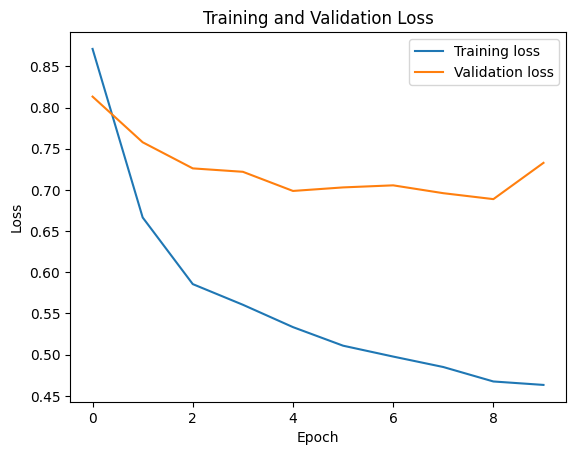

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()